# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


**Размер выборки**

In [3]:
len(labels)

7591

In [ ]:
labels

**Построю график распределения возраста по выборке**

Text(0, 0.5, 'число наблюдений')

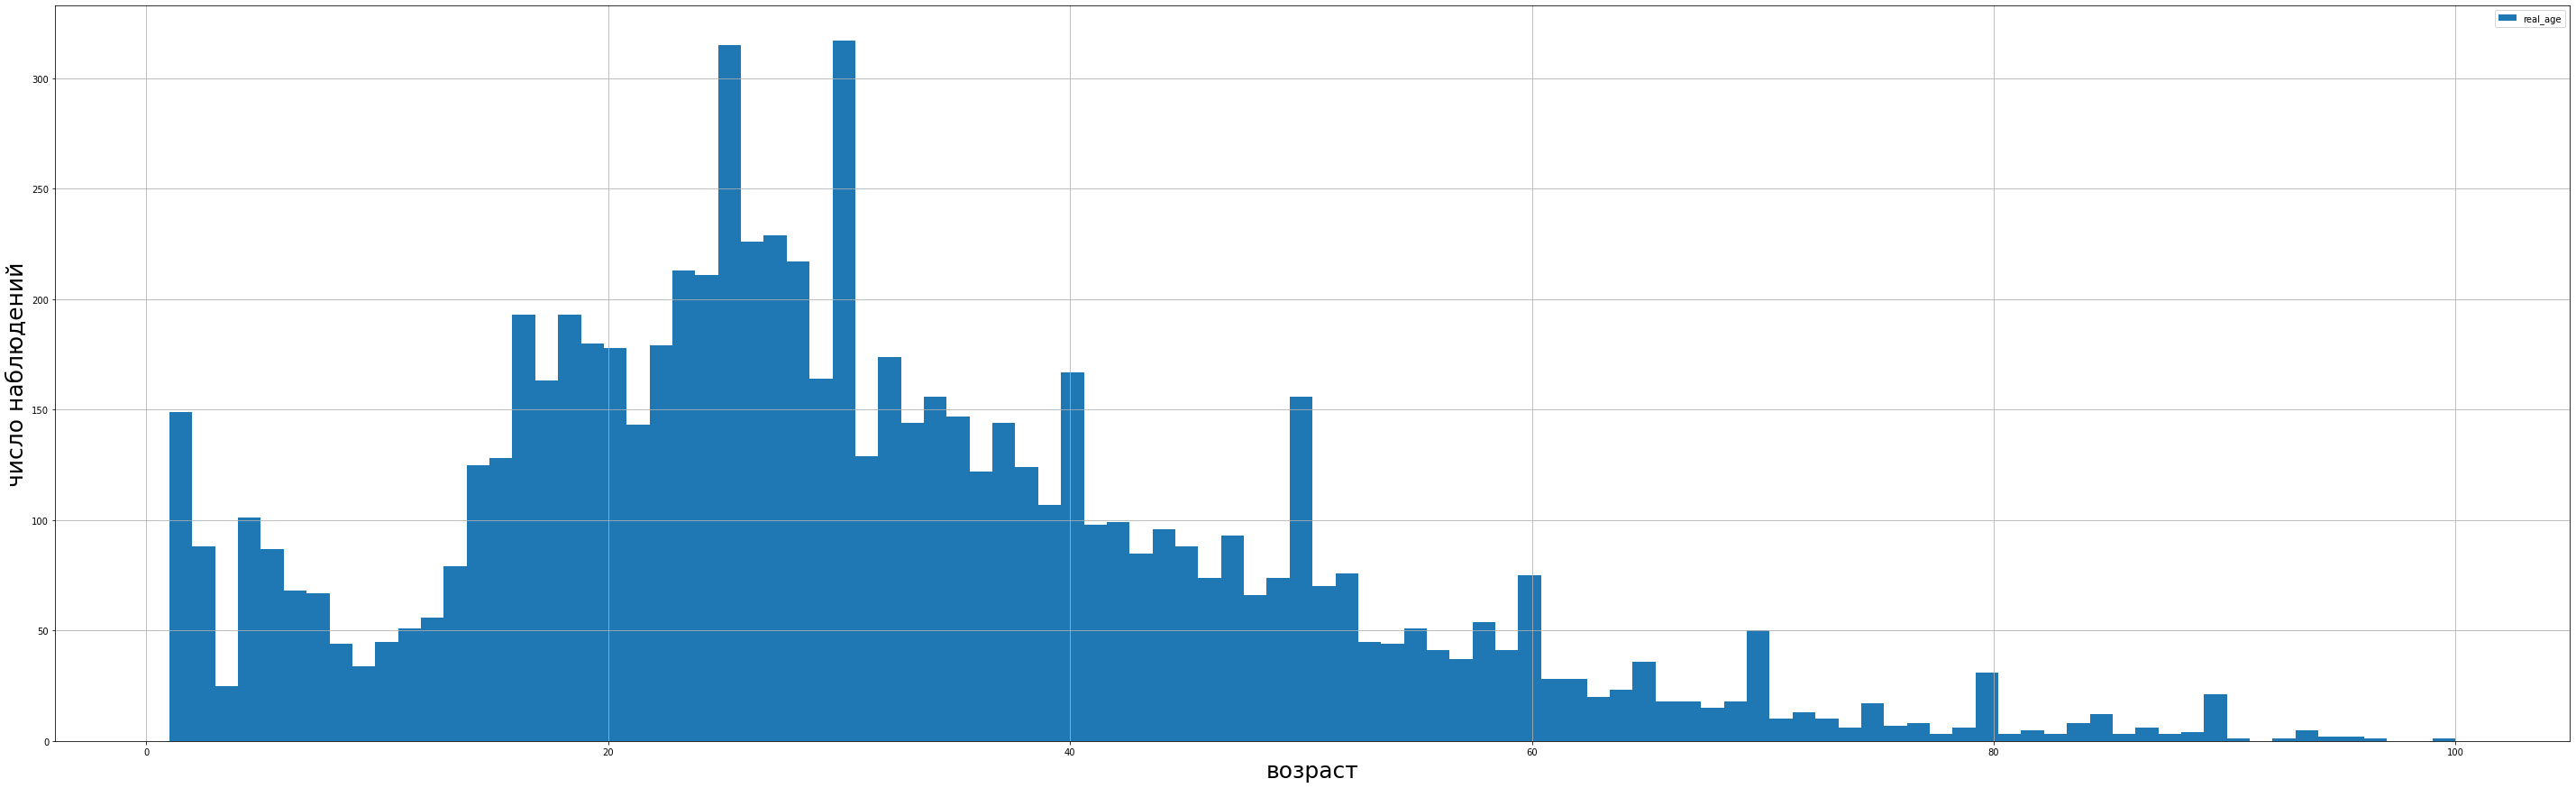

In [4]:
labels['real_age'].plot(bins=100, kind='hist', figsize=(50,15),legend=True, grid=True)
plt.xlabel('возраст', fontsize='25')
plt.ylabel('число наблюдений', fontsize='25')

**Вывод**
* Пики на кратных пяти или десяти годам возрастах 25,40,50,60,70,80 могут говорить о том что разметка проходила некорректно и вручную - округляли до красивой цифры.

**Выведем на экран 16 фотографий c возрастом**

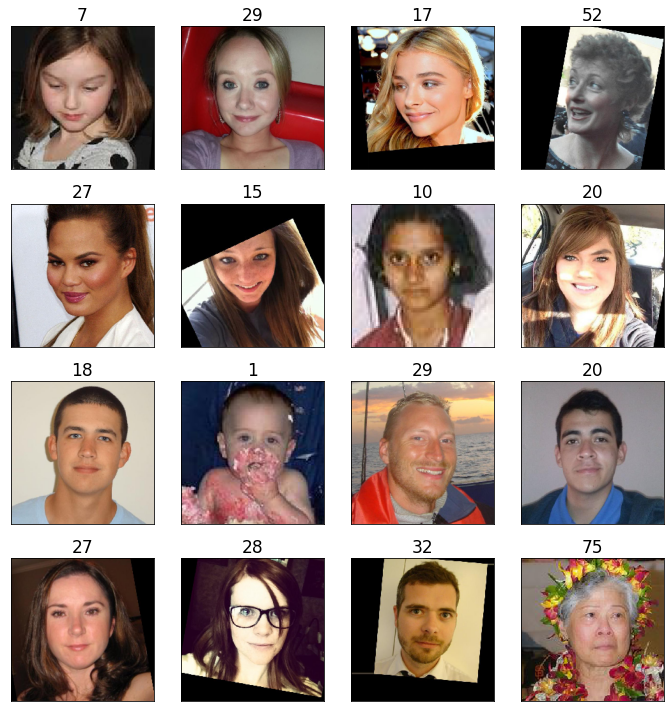

In [17]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i], fontsize='17')
    plt.tight_layout()

**Вывод**
* Модель может некоректно обучится т.к. есть искуственные смещенния данных к кратным 5-10 годам возрастам. И на реальных данных она будет промахиваться на 5-10 лет.

## Обучение модели

```python

def load_train(path):
    data_classes=pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25,
                                       vertical_flip=True, 
                                       horizontal_flip=True)            
 
 
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=data_classes,
                                           directory =path+'final_files/',
                                           x_col='file_name',
                                           y_col ='real_age',
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='raw',
                                           subset='training',                
                                           seed=10)
    return train_datagen_flow
 
def load_test(path):
    data_classes=pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
 
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=data_classes,
                                           directory =path+'final_files/',
                                           x_col='file_name',
                                           y_col ='real_age',
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='raw',
                                           subset ='validation',
                                           seed=10)
    return test_datagen_flow
 
 
 
def create_model(input_shape):
    optimizer=Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',#'imagenet', 
                    include_top=False)
 
    #backbone.trainable = False  
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
 
    return model
 
 
def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None, epochs=14,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_datagen_flow)
 
    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/14
2022-06-13 15:38:55.348628: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-13 15:38:55.644239: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 47s - loss: 265.6317 - mae: 11.8883 - val_loss: 938.6500 - val_mae: 25.8451
Epoch 2/14
178/178 - 39s - loss: 106.9521 - mae: 7.7170 - val_loss: 754.3647 - val_mae: 22.3964
Epoch 3/14
178/178 - 38s - loss: 80.5070 - mae: 6.7398 - val_loss: 237.0467 - val_mae: 11.3740
Epoch 4/14
178/178 - 38s - loss: 67.8837 - mae: 6.2217 - val_loss: 161.6693 - val_mae: 9.4659
Epoch 5/14
178/178 - 38s - loss: 54.6290 - mae: 5.6171 - val_loss: 105.3288 - val_mae: 7.7958
Epoch 6/14
178/178 - 38s - loss: 46.8326 - mae: 5.1881 - val_loss: 105.8932 - val_mae: 7.6297
Epoch 7/14
178/178 - 38s - loss: 40.3202 - mae: 4.8423 - val_loss: 100.3642 - val_mae: 7.7887
Epoch 8/14
178/178 - 38s - loss: 34.4965 - mae: 4.4695 - val_loss: 106.0864 - val_mae: 7.8563
Epoch 9/14
178/178 - 38s - loss: 31.5470 - mae: 4.2542 - val_loss: 106.9731 - val_mae: 7.6355
Epoch 10/14
178/178 - 38s - loss: 27.5505 - mae: 3.9797 - val_loss: 101.1369 - val_mae: 7.9314
Epoch 11/14
178/178 - 38s - loss: 24.4855 - mae: 3.7450 - val_loss: 73.3804 - val_mae: 6.5009
Epoch 12/14
178/178 - 38s - loss: 22.3670 - mae: 3.6092 - val_loss: 70.6887 - val_mae: 6.2190
Epoch 13/14
178/178 - 38s - loss: 19.9696 - mae: 3.4054 - val_loss: 81.7615 - val_mae: 6.6510
Epoch 14/14
178/178 - 39s - loss: 16.9052 - mae: 3.1424 - val_loss: 71.0279 - val_mae: 6.2920
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 71.0279 - mae: 6.2920
Test MAE: 6.2920

```

**Учитывая наличие выбросов в обучающей выборке модель показала отличный результат, она ошибается в среднем на 6.29 лет, можно использовать другой датасет с более коректными данными и результат будет выше.**